# Managing Projections in Geopandas

In our previous reading, we discussed the *concept* of projections -- their necessity for GIS analysis, and the trade-offs inherit in choosing a projection. 

In this reading, we'll turn to the *practice* of working with projections in geopandas. In particular, in this reading we'll discuss:

- How projection data is represented and stored in geopandasl
- How to *set* a projection when your data is missing embedded data on how its x-y coordinates should be interpreted.
- How to *re-project* data from one projection (with one set of distortion trade-offs) to another projection (with different tradeoffs).

## Coordinate Reference Systems (CRS)

When working with spatial data in geopandas, information about the data's projection is embodied in the data's *Coordinate Reference System*, or CRS. This is stored in the `.crs` attribute on all geodataframes:


In [1]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In this case, for example, we see that our CRS is perhaps the most well known CRS in geospatial analysis: `EPSG: 4326`, aka `WGS 84`. This CRS is famous because it's the CRS that corresponds to using longitude as the x-coordinate and latitude as the y-coordinate!

## Setting a CRS (when Missing)

*In theory,* all spatial data you get *should* come projection information embedded in the data itself. When this is the case, geopandas will automatically import that data into the `.crs` attribute when the data is loaded.

*In reality*, however, this will not always be the case. Because projection information is distinct from the geometric shape data, it is possible to get spatial data with points, lines or polygons, but no projection information telling you how the x-y values that make up those shapes correspond to locations on the earth. 

In these situations, we use the `.set_crs()` method to tell geopandas how the coordinates in a geodataframe should be interpreted.

Though this can happen with any data, it is most common when getting data that is stored in latitudes and longitudes. For example, it is not uncommon to be given a regular tabular dataset (say, a CSV) with latitude and longitude coordinates stored as regular columns. Because CSVs are not a spatial format like a shapefile or GeoJSON, there is no way to embed projection data in a CSV file, and as a result geopandas has no way of knowing the data in the spreadsheet is in latitudes and longitudes without our help.

To illustrate how we tell geopandas how to interpret a set of coordinates without embedded projection data, let's import a CSV consisting of data on all US Drone in Pakistan from 2007-2013 (this data comes from work by the Bureau of Investigative Journalism, and geocoded as part of some of my own past research).

In [2]:
import pandas as pd
df = pd.read_csv("../Example_Data/pk_drone_strikes_2007_2013.csv")
df.sample().T

,324
Unnamed: 0,324
OBJECTID,325
Location,Khassokhel near Mir Ali
BureauID,Ob273
Date_,2012-05-28
TotalKille,5-10
CiviliansK,0
ChildrenKi,0
Summary,Up to 10 alleged militants killed and 4 injure...
Latitude,32.96201


As we can see, each row of this data consists of a single drone strike, and includes a column with the (approximate) strike latitude and a column with the approximate strike longitude. 

To convert this pandas DataFrame into a GeoDataFrame, we'll use the `gpd.points_from_xy()` function:

<AxesSubplot:>

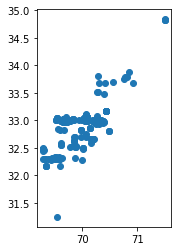

In [3]:
# Note that we usually say "latitude and longitude", 
# but longitude actually corresponds to the x coordinate, and 
# latitude corresponds to the y coordinate.

drone_strikes = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(x=df.Longitude, y=df.Latitude)
)
drone_strikes.plot()

We now have a GeoDataFrame, but it does not have a CRS defined -- *we* know that the x and y coordinates are longitudes and latitudes, but geopandas is not yet aware of that fact:

In [4]:
print(drone_strikes.crs)

None


To "tell" geopandas that these points are longitudes and latitudes, we now use the `.set_crs()` method. And in particular, we will set the CRS to the same projection we saw above -- `EPSG 4326` -- as follows:

In [5]:
drone_strikes = drone_strikes.set_crs(epsg=4326)
drone_strikes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

And now that we've defined a CRS, geopandas now understands how these shapes correspond to locations on the Earth. As a result, we can use tools like `.explore()` to overlay these strike locations on a map:

In [6]:
drone_strikes.explore()

## Re-Projecting Data

We've now learned about two tools for managing projections in geopandas: 

- `.crs` for accessing a GeoDataFrame's current CRS, and 
- `.set_crs()` for setting a CRS when none is defined.

But when doing GIS work, we also often want to *change* the CRS of our data -- a process called "re-projecting." 

As we discussed in our last reading, all projections result in distortions in our data. As a result, there is no "correct" projection for all situations; the "correct" projection depends on your application.

With that in mind, the first step in almost any GIS analysis will be to re-project your data to a projection that's well suited to *your* application. And for that we have `to_crs()`. 


To illustrate re-projecting data, let's use `to_crs()` to reproject our drone strike data. 

I'm interested in better understanding what portion of Pakistan was impacted by drone strikes during this period, and so what I would like to do is calculate the *area* of Pakistan that has been subject to drone strikes. 

While representing our data in latitudes and longitudes is sufficient to allow me to relate my data to locations in the real world, if I calculate an area in this project, the units will be "square degree latitude/longitude", which isn't a meaningful unit of measure. It's not even an easily convertable unit, to be clear -- because the vertical longitude lines converge at the poles, the distance between them contracts as you move to the poles. So it's basically meaningless. 

Indeed, that's the reason that we've been seeing warning messages any time I try and do a spatial operation that entails measuring distances in our past readings -- when geopandas sees the user try and use a function like `sjoin_nearest` with data that has a CRS of EPSG 4326, it tries to warn them that because the function is measuring distances behind the scenes, and the data is in longitudes and latitudes, it's not a particularly meaningful operation!

So instead of EPSG 4326, let's use the UTM Zone 42N, known as EPSG 32642.

### Choosing a Projection

Uh, what? Where did that come from?!

So there are *lots* of projections, and you can find *great* summaries of their various properties [here](https://pubs.usgs.gov/gip/70047422/report.pdf) and [here](https://www.arcgis.com/sharing/rest/content/items/e8b85d508d2c4f21a3dec4e52dc7d9c4/data).

But if you're working with a relatively small area (here, a portion of the relatively geographically small country of Pakistan), a good "default" projection is to find the [Universal Transverse Mercator (UTM)](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) zone that corresponds to the area you're studying. This is a collection of projections each tailored for relatively small strips of the Earth (6 degrees of Longitude):

![utm zones](./images/utm_zones.png)

And each projection does a pretty solid job of minimizing distortions -- and balancing them relatively evenly -- for data inside it's zone and data in either of the neighboring zones. So... it's not always the right answer, but it's a pretty solid go to. 

So here I googled UTM Zones, found the one for Pakistan, then googled that to get the [EPSG code here](https://epsg.io/32642).

OK, so let's project!

<AxesSubplot:>

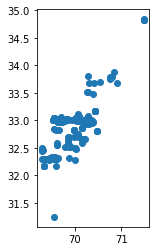

In [7]:
# Look at data pre-projection
drone_strikes.plot()

<AxesSubplot:>

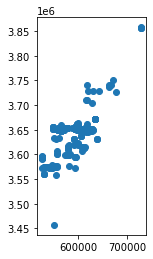

In [8]:
# and after!
drone_strikes_projected = drone_strikes.to_crs(epsg=32642)
drone_strikes_projected.plot()

Because Pakistan is not far from the equator, latitude and longitude weren't distorting things too much, so these plots don't look massively different, but we do now have data with a unit of distance (meters) that makes sense! 

So now we can measure the area of Pakistan impacted by drone strikes by (a) merging all the points into a single MultiPoint object with `unary_union`, then (b) creating a convex-hull around those points:

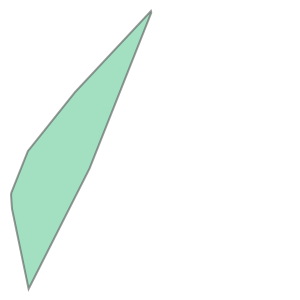

In [9]:
area_impacted = drone_strikes_projected.unary_union.convex_hull
area_impacted

In [10]:
# Area in Sq Kilometers
area_impacted.area / 1_000_000

23514.256094530607

We know the area of Pakistan is 796,095 sq kilometers, so that means drone strikes were occuring over:

In [11]:
print(f"Drone strikes ranged over {23_514/796_095:.2%} of Pakistan's land area")

Drone strikes ranged over 2.95% of Pakistan's land area


So a surprisingly small area, given there were 363 drone strikes during this period. 

### Warnings About Geographic Projections

In our previous readings, I repeatedly ignored warnings I told you I would never ignore for real analyses. Those warnings occurred because I was doing things like calculating distances between points (in order to find the "nearest" object when using `sjoin_nearest`) while the data was in latitudes and longitudes.

I ignored those warnings at the time because I didn't want to get into projections at that point in the lesson. Now that we understand projections, though, I want to emphasize: You should NEVER ignore those warnings in real work! They're telling you that you're working with data whose x-y coordinates are in default state that is probably causing strange distortions that you don't want. So please don't ignore them!


### Setting versus Re-Projecting

One of the most common sources of confusion among students is the distinction between *setting* a CRS (`.set_crs()`), and *re-projecting* to a new CRS (`.to_crs()`), so let's take a moment to make sure the distinction is clear. 

When you set a CRS with `.set_crs()`, you are telling geopandas how to interpret the x-y coordinates in your data. But you aren't changing your data -- you are simply providing geopandas with the information it needs to make full use of the shapes it is already storing. 

But when you re-project your data, you're telling geopandas to *change the x-y coordinates in your data* from one projection to another. You are making a subjective decision to convert your data to a new projection that trades off the distortions inherent in projecting data in a manner different from its current projection.

## How Projections are Represented

Now that we're in the business of specifying projections, it makes sense to discuss how projections are represented.

There are two main representations of projections to be aware of:

- **EPSG Codes:** Many common projections have been assigned codes in the [EPSG Geodetic Parameter Dataset](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset). As a result, EPSG codes have become a pretty standard way of specifying projections. How do I find the EPSG code for a projection? Google it, and you'll probably end up at [epsg.io](epsg.io). :)
- **WKT Strings:** The other representation you are likely to come across are WKT strings. These are big strings that *actually* tell you all the details of a projection. For example, here's the full WKT string for the UTM Zone 42 projection we used above:

In [12]:
import pyproj
print(pyproj.CRS.from_epsg(32642).to_wkt(pretty=True))

PROJCRS["WGS 84 / UTM zone 42N",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 42N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",69,
            ANG

But yeah -- usually you can get away with using EPSG codes!